In [2]:
import pandas as pd

In [3]:
df_car_price = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [4]:
df_car_price = df_car_price[[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]]

In [7]:
df_car_price.rename(
    dict(zip(df_car_price.columns, df_car_price.columns.str.replace(' ', '_')))
    , axis=1
    , inplace=True
)
df_car_price.rename(
    dict(zip(df_car_price.columns, df_car_price.columns.str.lower()))
    , axis=1
    , inplace=True
)
df_car_price.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [8]:
df_car_price.fillna(0, inplace=True)

In [9]:
df_car_price['above_average'] = df_car_price.msrp>df_car_price.msrp.mean()
df_car_price['above_average'] = df_car_price['above_average'].astype(int)

In [10]:
df_car_price.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_car_price, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=1)

# Question 1: ROC AUC feature importance

In [12]:
from sklearn.metrics import roc_auc_score

for col in ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']:
    print(f"""
        {col}: {
            max(
                roc_auc_score(df_train['above_average'], df_train[col])
                , roc_auc_score(-df_train['above_average'], df_train[col])
            )
        }""")
# engine_hp


        engine_hp: 0.9171031265539011

        engine_cylinders: 0.766116490165669

        highway_mpg: 0.6330587871772014

        city_mpg: 0.6734244643245233


# Question 2

In [13]:
features = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']
target = ['above_average']

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


train_dicts = df_train[features].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train[target].values.ravel())

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(df_val[target], y_pred), 4)

0.9797

# Question 3: Precision and Recall

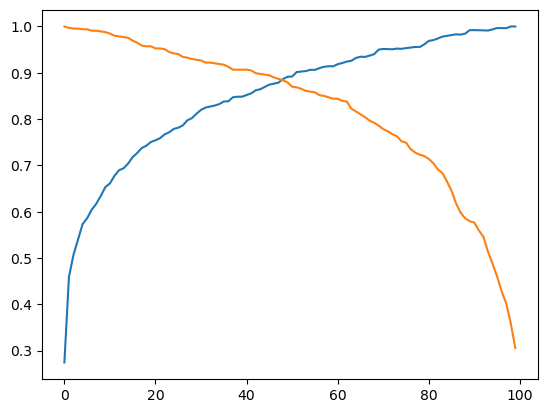

0.0027110185549990007 [0.48]


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import numpy as np

thresholds = np.arange(0,1,0.01)
precision, recall = zip(*[(precision_score(df_val[target], y_pred>threshold), recall_score(df_val[target], y_pred>threshold)) for threshold in np.arange(0,1,0.01)])

plt.plot(precision)
plt.plot(recall)
plt.show()

min_diff = np.min(np.abs(np.array(precision) - np.array(recall)))
print(min_diff, thresholds[np.abs(np.array(precision) - np.array(recall)) == min_diff])

# Question 4: F1 score

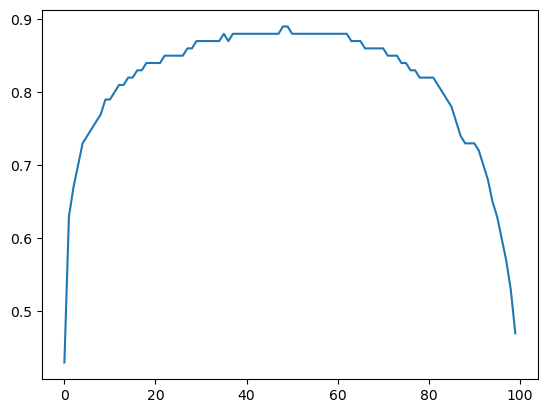

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.arange(0,1,0.01)
f1_score = [round(f1_score(df_val[target], y_pred>threshold),2) for threshold in np.arange(0,1,0.01)]
plt.plot(f1_score)
plt.show()

# Question 5: 5-Fold CV

In [17]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_train_val = pd.concat([df_train, df_val], axis=0).reset_index()

lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

aucs = []
for i, (train_index, val_index) in enumerate(kf.split(df_train_val)):
    train_dicts = df_train_val[features].loc[train_index,:].to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, df_train_val[target].loc[train_index].values.ravel())
    
    val_dicts = df_train_val[features].loc[val_index,:].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    
    aucs.append(
        round(roc_auc_score(df_train_val[target].loc[val_index,:], y_pred), 4)
    )

np.std(aucs)

0.003215338240372224

# Question 6: Hyperparemeter Tuning

In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_train_val = pd.concat([df_train, df_val], axis=0).reset_index()

lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

for c in [0.01, 0.1, 0.5, 10]:
    aucs = []
    for i, (train_index, val_index) in enumerate(kf.split(df_train_val)):
        train_dicts = df_train_val[features].loc[train_index,:].to_dict(orient='records')
        dv = DictVectorizer()
        X_train = dv.fit_transform(train_dicts)
        
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, df_train_val[target].loc[train_index].values.ravel())
        
        val_dicts = df_train_val[features].loc[val_index,:].to_dict(orient='records')
        X_val = dv.transform(val_dicts)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        
        aucs.append(
            round(roc_auc_score(df_train_val[target].loc[val_index,:], y_pred), 4)
        )

    print(f"C:{c}, Mean: {np.mean(aucs)}, Std: {np.std(aucs)}")

C:0.01, Mean: 0.9516199999999999, Std: 0.003875770891061527
C:0.1, Mean: 0.97148, Std: 0.0034953683639925826
C:0.5, Mean: 0.97582, Std: 0.003850402576354844
C:10, Mean: 0.9788, Std: 0.00457908287760768
